In [42]:
from tinygrad import Tensor
import tinygrad.nn as nn

class Base:
    def __init__(self, layers):
        self.layers = [nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]

    def __call__(self, x):
        for i, layer in enumerate(self.layers): x = layer(x).tanh() if i != len(self.layers) - 1 else layer(x)
        return x

class AutoEncoder:
    def __init__(self, layers):
        self.encoder = Base(layers)
        self.decoder = Base(list(reversed(layers)))
    def __call__(self, x):
        return self.decoder(self.encoder(x))

class AutoEncoderLoss():
    def __init__(self, L1_regularization: float = None, contrastive_regularization: float = None):
        self.l1_lambda = L1_regularization # L1 sparcity regularization
        self.l2_lambda = contrastive_regularization # L2 constrastive 

    
    def __call__(self, x, y, autoencoder: AutoEncoder = None):
        total = ((x - y)**2).sum(axis=1).sum(axis=0)
        l1_lambda = None if autoencoder is None else self.l1_lambda
        total += l1_lambda * 1 if l1_lambda is not None else 0 # still missing something here
        return total

In [43]:
import tinygrad
from tinygrad import Tensor
from tinygrad.dtype import dtypes
import numpy as np
from tqdm import tqdm
import torchaudio
from sklearn.model_selection import train_test_split

In [50]:
autoencoder = AutoEncoder([80, 64, 10])
opt = tinygrad.nn.optim.SGD([layer.weight for layer in autoencoder.encoder.layers] + [layer.weight for layer in autoencoder.decoder.layers], lr=1e-7)

In [51]:
audio, sr = torchaudio.load('../Data/240528 Subject 3.wav')
spectrogram = torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=80)(audio).numpy()
spectrogram.shape

(1, 80, 190349)

In [52]:
X_train = spectrogram[0][:, :170000]
X_test = spectrogram[0][:, 170000:]

In [53]:
nsteps = 20000
batch_size = 128

steps = []
losses = []
evals = []

def sparse_categorical_crossentropy(x, y):
    z = ((x - y)**2).sum(axis=1).sum(axis=0)
    return z

def eval(autoencoder, X_test):
    losses = []
    for _ in range(20):
        samp = np.random.randint(0, X_train.shape[0], size=(batch_size))
        batch = Tensor(X_train[:, samp], requires_grad=False).T
        labels = Tensor(X_train[:, samp]).T

        out = autoencoder(batch)
        losses.append(sparse_categorical_crossentropy(out, labels))
    return (sum(losses) / len(losses)).numpy()

In [54]:
with Tensor.train():
  for step in tqdm(range(nsteps)):
    # random sample a batch
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))
    batch = Tensor(X_train[:, samp], requires_grad=False).T
    labels = Tensor(X_train[:, samp]).T

    out = autoencoder(batch)
    loss = sparse_categorical_crossentropy(out, labels)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if step % 100 == 0:
      steps.append(step)
      losses.append(loss.numpy())
      evals.append(eval(autoencoder, X_test))
      # print(loss.numpy())

print("Equivalent number of epochs trained for: ", nsteps * batch_size / X_train.shape[0])

100%|██████████| 20000/20000 [02:29<00:00, 133.49it/s]

Equivalent number of epochs trained for:  32000.0


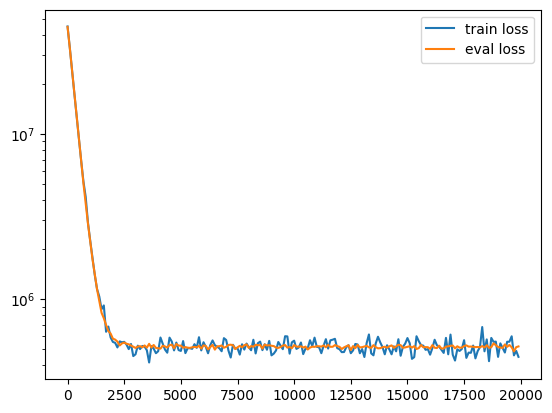

In [55]:
import matplotlib.pyplot as plt

plt.semilogy(steps, losses, label="train loss")
plt.semilogy(steps, evals, label="eval loss")
plt.legend()

In [79]:
from tinygrad.nn.state import safe_save, safe_load, get_state_dict, load_state_dict

state_dict = get_state_dict(autoencoder)

# then we can just save it to a file
safe_save(state_dict, "model.safetensors")